# Image Histogram-Based Classification

In [1]:
train_path = "../../Database/260220_high"
test_path = "../../Database/260220_high"

## HistogramColorClassifier class

### References:
https://mpatacchiola.github.io/blog/2016/11/12/the-simplest-classifier-histogram-intersection.html
https://github.com/mpatacchiola/deepgaze/blob/master/deepgaze/color_classification.py

In [2]:
import numpy as np
import os
import cv2
import sys
import matplotlib.pyplot as plt

In [3]:
class HistogramColorClassifier:
    """ Classifier for comparing an image based on color histograms """

    def __init__(self, channels=[0, 1, 2], hist_size=[10, 10, 10], hist_range=[0, 256, 0, 256, 0, 256], hist_type='BGR', name_list=list()):
        """ Init the classifier """
        self.channels = channels
        self.hist_size = hist_size
        self.hist_range = hist_range
        self.hist_type = hist_type
        self.name_list = list(name_list)
        self.model_list = [None] * len(name_list)
        self.model_list_cntr = [1] * len(name_list)

    def addModelHistogram(self, model_frame, name=''):
        """ Add the histogram to internal container """
        if   (self.hist_type=='HSV'):  model_frame = cv2.cvtColor(model_frame, cv2.COLOR_BGR2HSV)
        elif (self.hist_type=='GRAY'): model_frame = cv2.cvtColor(model_frame, cv2.COLOR_BGR2GRAY)
        elif (self.hist_type=='RGB'):  model_frame = cv2.cvtColor(model_frame, cv2.COLOR_BGR2RGB)
        elif (self.hist_type=='LAB'):  model_frame = cv2.cvtColor(model_frame, cv2.COLOR_BGR2LAB)
        hist = cv2.calcHist([model_frame], self.channels, None, self.hist_size, self.hist_range)
        hist = cv2.normalize(hist, hist).flatten()
        if name == '': 
            name = str(len(self.model_list))
        if name not in self.name_list:
            self.model_list.append(hist)
            self.name_list.append(name)
        else:
            for i in range(len(self.name_list)):
                if self.name_list[i] == name:
                    if self.model_list[i] is None:
                        self.model_list[i] = hist                        
                    else:
                        self.model_list[i] += ((hist - self.model_list[i])/self.model_list_cntr[i])
                    self.model_list_cntr[i] += 1
                    break

    def returnHistogramComparison(self, hist_1, hist_2, method='intersection'):
        """ Return the comparison value of two histograms """        
        if cv2.__version__.split(".")[0] == '3':
            if(method=="intersection"):
                comparison = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_INTERSECT)
            elif(method=="correlation"):
                comparison = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_CORREL)
            elif(method=="chisqr"):
                comparison = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_CHISQR)
            elif(method=="bhattacharyya"):
                comparison = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_BHATTACHARYYA)
            else:
                raise ValueError('[DEEPGAZE] color_classification.py: the method specified ' + str(method) + ' is not supported.')
        else:
            if(method=="intersection"):
                comparison = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_INTERSECT)
            elif(method=="correlation"):
                comparison = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_CORREL)
            elif(method=="chisqr"):
                comparison = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_CHISQR/ cv2.HISTCMP_CHISQR_ALT)
            elif(method=="bhattacharyya"):
                comparison = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_BHATTACHARYYA)
            else:
                raise ValueError('[DEEPGAZE] color_classification.py: the method specified ' + str(method) + ' is not supported.')
        return comparison

    def returnHistogramComparisonArray(self, image, method='intersection'):
        """ Return the comparison array between all the model and the input image. """
        if(self.hist_type=='HSV'): image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif(self.hist_type=='GRAY'): image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        elif(self.hist_type=='RGB'): image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        comparison_array = np.zeros(len(self.model_list))
        image_hist = cv2.calcHist([image], self.channels, None, self.hist_size, self.hist_range)
        image_hist = cv2.normalize(image_hist, image_hist).flatten()
        counter = 0
        for model_hist in self.model_list:
            comparison_array[counter] = self.returnHistogramComparison(image_hist, model_hist, method=method)
            counter += 1
        return comparison_array

## Usage Example

### Build

In [4]:
classes_labels = ('Type1', 'Type2', 'Type3', 'Type4', 'Type5', 'Type6')
classes_num = len(classes_labels)

my_classifiers = {'BGR': HistogramColorClassifier(channels = [0, 1, 2], 
                                                  hist_size = [128, 128, 128],
                                                  hist_range = [0, 256, 0, 256, 0, 256],
                                                  hist_type = 'BGR',
                                                  name_list = classes_labels),

                  'HSV': HistogramColorClassifier(channels = [0, 1, 2], 
                                                  hist_size = [128, 128, 128],
                                                  hist_range = [0, 256, 0, 256, 0, 256],
                                                  hist_type = 'HSV',
                                                  name_list = classes_labels),

                  'LAB': HistogramColorClassifier(channels = [0, 1, 2], 
                                                  hist_size = [128, 128, 128],
                                                  hist_range = [0, 256, 0, 256, 0, 256],
                                                  hist_type = 'LAB',
                                                  name_list = classes_labels)}

### Train

In [5]:
for class_id in range(1,classes_num+1):
    
    root = '%s/type%d' % (train_path, class_id)
    
    for file in os.listdir(root):
        
        if file == '1.jpg': # test-set
            continue
        
        if file.endswith(".jpg"):
            
            for _,cls in my_classifiers.items():
                cls.addModelHistogram(cv2.imread(os.path.join(root,file)), 'Type%d' % class_id)

### Test

BGR
File: ../../Database/260220_high/type1/1.jpg
Comparison Array: [7.51853373 5.30210885 4.74427057 6.48226885 3.70348015 2.00372976]
Distribution Array: [0.25268652 0.17819584 0.15944774 0.21785923 0.12446835 0.06734232]
Class ID: Type1


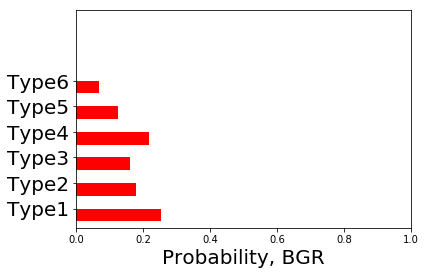

HSV
File: ../../Database/260220_high/type1/1.jpg
Comparison Array: [6.58314043 4.83086812 4.18866061 5.31007316 3.38667795 1.93852313]
Distribution Array: [0.25090154 0.18411764 0.15964135 0.20238145 0.12907559 0.07388243]
Class ID: Type1


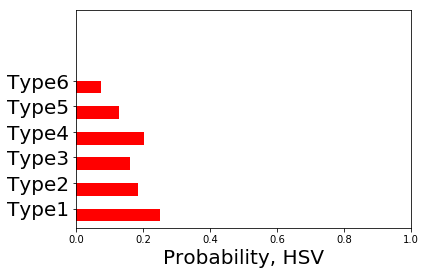

LAB
File: ../../Database/260220_high/type1/1.jpg
Comparison Array: [0.22793373 0.20668419 0.06863756 0.07465535 0.08882906 0.28880096]
Distribution Array: [0.23853897 0.21630074 0.07183111 0.07812889 0.09296208 0.30223821]
Class ID: Type6


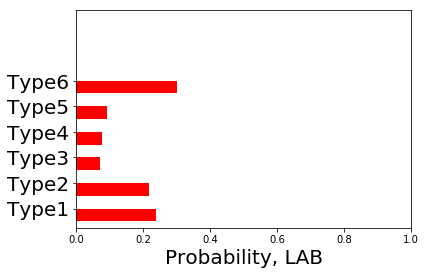

BGR
File: ../../Database/260220_high/type2/1.jpg
Comparison Array: [7.14260252 5.48254775 4.90651981 7.85584485 4.73840957 0.62688913]
Distribution Array: [0.23225851 0.17827792 0.15954702 0.25545126 0.15408052 0.02038477]
Class ID: Type4


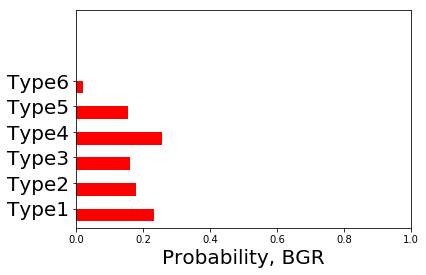

HSV
File: ../../Database/260220_high/type2/1.jpg
Comparison Array: [6.42398363 4.77065166 4.38888357 6.83096274 4.44950696 0.56172017]
Distribution Array: [0.23423218 0.17394816 0.16002808 0.24907151 0.16223854 0.02048152]
Class ID: Type4


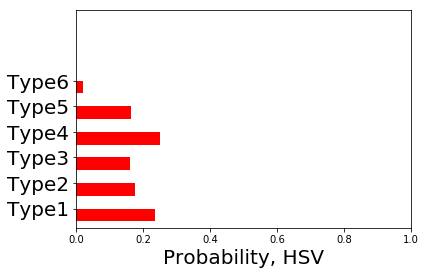

LAB
File: ../../Database/260220_high/type2/1.jpg
Comparison Array: [0.21147374 0.26256319 0.05405229 0.10133978 0.07621357 0.27326174]
Distribution Array: [0.21603107 0.26822151 0.05521713 0.10352368 0.077856   0.27915061]
Class ID: Type6


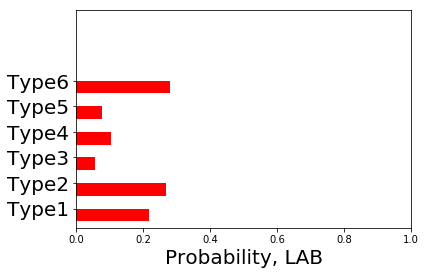

BGR
File: ../../Database/260220_high/type3/1.jpg
Comparison Array: [5.94177363 2.6219155  5.66604737 6.74853658 3.81156084 0.24717331]
Distribution Array: [0.23731964 0.1047216  0.2263069  0.26954246 0.15223708 0.00987232]
Class ID: Type4


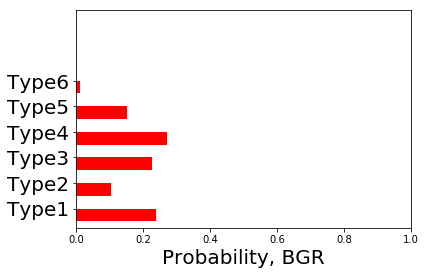

HSV
File: ../../Database/260220_high/type3/1.jpg
Comparison Array: [5.37397589 2.06695491 5.01915925 5.9351202  3.56261575 0.19427161]
Distribution Array: [0.24259445 0.09330741 0.22657715 0.26792588 0.16082521 0.0087699 ]
Class ID: Type4


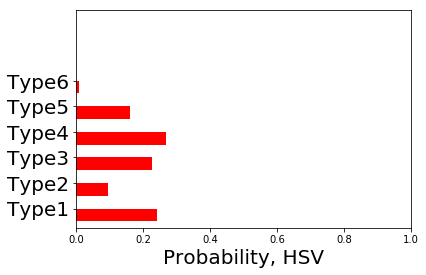

LAB
File: ../../Database/260220_high/type3/1.jpg
Comparison Array: [0.17075706 0.27088741 0.1079726  0.14215498 0.10862429 0.11549458]
Distribution Array: [0.1864382  0.29576384 0.11788806 0.15520952 0.11859959 0.1261008 ]
Class ID: Type2


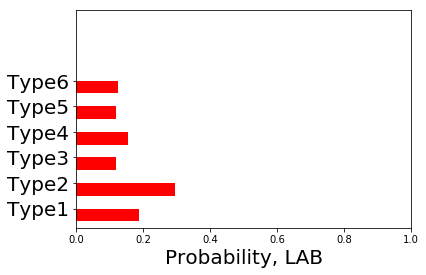

BGR
File: ../../Database/260220_high/type4/1.jpg
Comparison Array: [5.36140796 1.29676942 2.87457511 3.96181831 5.12851755 0.26330141]
Distribution Array: [0.2838768  0.06866158 0.15220353 0.20977108 0.27154568 0.01394133]
Class ID: Type1


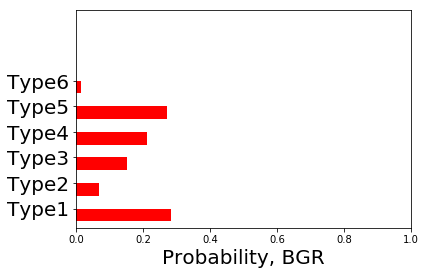

HSV
File: ../../Database/260220_high/type4/1.jpg
Comparison Array: [5.03378954 0.94684944 2.60590297 3.78055162 5.03693909 0.21557956]
Distribution Array: [0.28569241 0.05373838 0.14789786 0.21456497 0.28587117 0.0122352 ]
Class ID: Type5


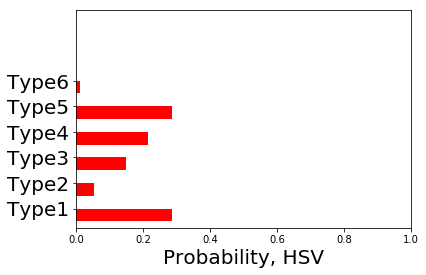

LAB
File: ../../Database/260220_high/type4/1.jpg
Comparison Array: [0.20175973 0.32627656 0.12238043 0.13834441 0.14758881 0.1312096 ]
Distribution Array: [0.18899155 0.30562844 0.1146357  0.12958941 0.13824878 0.12290611]
Class ID: Type2


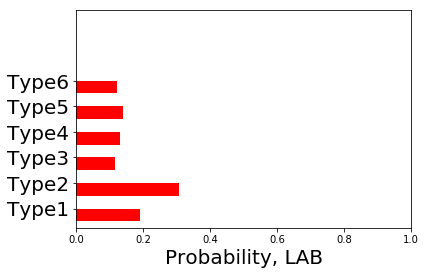

BGR
File: ../../Database/260220_high/type5/1.jpg
Comparison Array: [ 6.07113298  1.98294163  3.81395722  3.59065143 11.29145845  0.49593181]
Distribution Array: [0.22282598 0.07277899 0.1399819  0.13178601 0.41442516 0.01820196]
Class ID: Type5


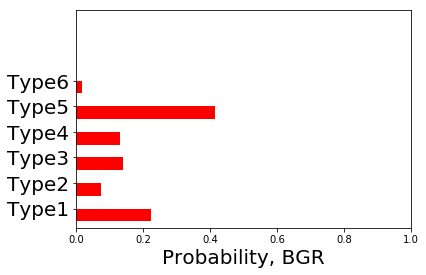

HSV
File: ../../Database/260220_high/type5/1.jpg
Comparison Array: [ 5.72884133  1.69014329  3.47650603  3.31180815 11.3775115   0.43412904]
Distribution Array: [0.22017966 0.06495819 0.13361444 0.12728452 0.43727807 0.01668512]
Class ID: Type5


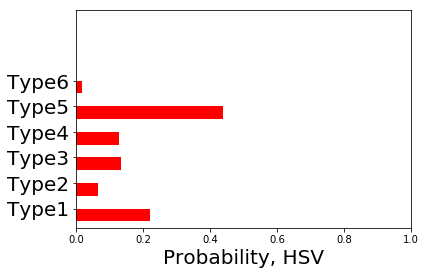

LAB
File: ../../Database/260220_high/type5/1.jpg
Comparison Array: [0.22816027 0.33395028 0.18337188 0.20923018 0.16238991 0.15539194]
Distribution Array: [0.17930158 0.26243751 0.14410427 0.16442522 0.12761542 0.122116  ]
Class ID: Type2


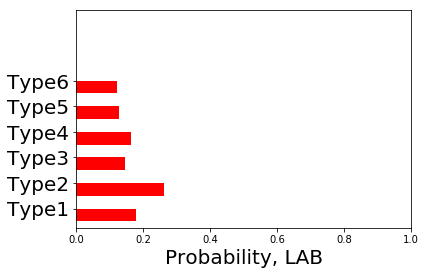

BGR
File: ../../Database/260220_high/type6/1.jpg
Comparison Array: [3.08602701 2.4577339  3.15909052 1.2592276  6.33758483 1.49630073]
Distribution Array: [0.17341162 0.13810625 0.17751724 0.07075917 0.35612483 0.0840809 ]
Class ID: Type5


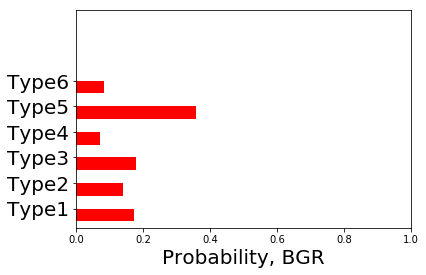

HSV
File: ../../Database/260220_high/type6/1.jpg
Comparison Array: [2.90984304 2.38632527 3.03114807 1.12188772 6.31922026 1.25872401]
Distribution Array: [0.17089433 0.14014826 0.17801854 0.06588817 0.37112616 0.07392453]
Class ID: Type5


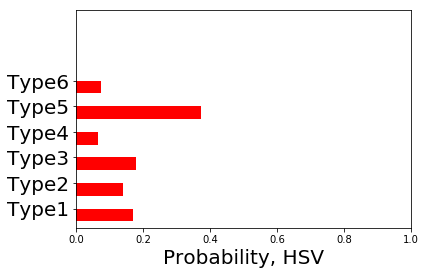

LAB
File: ../../Database/260220_high/type6/1.jpg
Comparison Array: [0.10789059 0.05117052 0.038539   0.03378272 0.0471824  0.08870007]
Distribution Array: [0.29376746 0.13932848 0.10493504 0.09198451 0.12846954 0.24151498]
Class ID: Type1


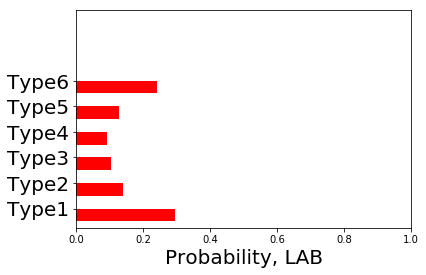

In [6]:
for class_id in range(1,classes_num+1):

    root = '%s/type%d' % (test_path, class_id)
    
    for file in os.listdir(root):

        if file == '1.jpg': # test-set
        
            for k,cls in my_classifiers.items():

                test_image = cv2.imread(os.path.join(root,file))
                comparison_array = cls.returnHistogramComparisonArray(test_image, method="intersection")
                comparison_distribution = comparison_array / np.sum(comparison_array)
                class_id = np.argmax(comparison_distribution) + 1

                # Print
                print(k)
                print('File: %s' % os.path.join(root,file))
                print("Comparison Array: %s" % str(comparison_array))
                print("Distribution Array: %s" % str(comparison_distribution))
                print("Class ID: Type%d" % class_id)

                # Plot
                plt.barh(np.arange(classes_num), comparison_distribution, 0.5, color='r')
                plt.yticks(np.arange(classes_num) + 0.25, classes_labels, rotation=0, size=20)
                plt.xlim(0.0, 1.0)
                plt.ylim(-0.5, 8.0)
                plt.xlabel('Probability, %s' % k, size=20)
                plt.show()

In [7]:
print('Completed Successfully')

Completed Successfully
